# Evaluating the Likelihood

The goal of this code is to evaluate $\mathcal{L}(WZ\vert n(z))$, with the marginalisation over nuisance parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
from scipy.interpolate import interp1d
import time

***
# Open the WZ

Run only one of these two cells, depending whether you want Redmagic or BOSS

In [11]:
## Redmagic
Njkk=101
nalpha=0
Nz=38

z_min=0.15
z_max=0.89
dz=(z_max-z_min)/(Nz-1)
z_wz=np.array([z_min+i*dz for i in range(Nz)])

chemin_fichier_pickle = "../../BFD/Bins/bfd_masked_wide_WC_v2_dhayaa_bin0.pickle"

In [103]:
## BOSS
Njkk=50
Nz=26
nalpha=0

z_min=0.09
z_max=0.09+25*0.04
dz=(z_max-z_min)/(Nz-1)
z_wz=np.array([z_min+i*dz for i in range(Nz)])

chemin_fichier_pickle = "../../BFD/Bins/bfd_masked_Boss_dhayaa_bin0_lesspoint.pickle"

### From Jkk, wz and Cov

In [104]:
with open(chemin_fichier_pickle, 'rb') as fichier_pickle:
    donnees = pickle.load(fichier_pickle)

C=np.copy(donnees)
D0=np.array([[C[i][j][nalpha] for j in range(Njkk)]for i in range(Nz)],dtype=np.float64)

w_wz=np.array([1/Njkk*np.sum(D0[j]) for j in range(Nz)],np.float64)
Cov_wz =np.array([[ ( Njkk-1)/Njkk* np.sum((D0[imat] - w_wz[imat]) * (D0[jmat] - w_wz[jmat])) for jmat in range(Nz)] for imat in range(Nz)],np.float64)    

Sigma_wz=np.linalg.inv(Cov_wz)   

### wdm, biases and fiducial alpha

In [105]:
w_dm_red=np.array([0.01076799, 0.01061811, 0.01047219, 0.01032262, 0.01017066, 0.01002699,
 0.00989498, 0.00976879, 0.00964356, 0.00951518, 0.00938471, 0.00926324,
 0.00915144, 0.00904439, 0.00893817, 0.00883062, 0.00872194, 0.00861449,
 0.00851164, 0.00841671, 0.00832724, 0.0082357 , 0.00814301, 0.00805622,
 0.00797556, 0.00789384, 0.00781 ,   0.00773163, 0.00765887, 0.0075847,
 0.00750879, 0.00743771, 0.0073716,  0.00730417, 0.00723519, 0.00717052,
 0.00711024, 0.00704875])

w_dm_boss=np.array([0.01853142, 0.01832976, 0.01813452, 0.0179447 , 0.01776087,
       0.01758888, 0.01742159, 0.01725827, 0.01709932, 0.01694431,
       0.01679868, 0.01665666, 0.01651721, 0.01638115, 0.01624805,
       0.01612241, 0.01599989, 0.01587935, 0.01576096, 0.01564534,
       0.01553518, 0.01542617, 0.01531971, 0.0152156 , 0.01511252,
       0.01501431])**0.5*0.04**0.5

br_red=np.array([1.7955411 , 1.69448373, 1.83247266, 1.97978608, 2.07769525,
       1.9417623 , 1.79785843, 1.90349682, 1.91040197, 1.76467487,
       1.83392512, 1.8686583 , 2.00594196, 2.02457084, 1.82708188,
       1.86070826, 1.89892959, 1.9693689 , 2.00579554, 2.10842901,
       2.09450636, 2.10567461, 2.17576824, 2.10408421, 2.05093593,
       2.25956157, 2.49234576, 2.38560509, 2.48973138, 2.37859695,
       2.33983774, 2.46812119, 2.51668513, 2.38913967, 2.50348757,
       2.37784525, 2.18182427, 2.57225389])
br_boss=np.array([1 for i in range(26)])


alpha_boss=np.array([3 for i in range(26)])
alpha_red=np.array([-1 for i in range(38)])

***
## Beginning of the Likelihood code
The Likelihood is:

$\mathcal{L}({\rm WZ}\vert n,\,\omega_{\rm DM},\, b_r)=\int d\mathbf{s}\,d\mathbf{p}\, \exp\left({-\frac{1}{2}(\omega_{\rm wz}- \omega_{\rm mod})^{\top}}\Sigma_{\rm wz}(\omega_{\rm wz}- \omega_{\rm mod})\right) p(s)\,p(p),$.

We start by defining:

$q=(s,\,p)$

$c_i=\omega_{wz}(z_i)-n(z_i)\,b_r(z_i)\,\omega_{\rm DM}$

$A=\left( \hspace{0.3cm}(n(z_i)\,b_r(z_i)\,\omega_{\rm DM}(z_i)\,a_k \,\mathcal{P}_k(u(z_i)))_{i,k}\hspace{0.3cm}\vert\hspace{0.3cm} M_{z_i,\,k}\hspace{0.3cm}\right)$

and we assume Gaussian priors $p(q)\sim\mathcal{N}(\mu_q,\,\Sigma_q)$,

We then furhter define:

$\alpha=A^{\top}\Sigma_{\rm wz}\,A+\Sigma_q$
    
$\beta=A^{\top} \Sigma_{\rm wz}\cdot c+\Sigma_q\cdot \mu_q$
    
$\gamma=c^{\top}\cdot\Sigma_{\rm wz}\cdot c+\mu_q^{\top}\cdot\Sigma_q\cdot \mu_q.$
    
We have the following analytical expression: 

$\mathcal{L}({\rm WZ}\vert n,\,\omega_{\rm DM},\, b_r)\propto \vert \alpha\vert^{-\frac{1}{2}}\exp\left(-\frac{1}{2}(\gamma-\beta^{\top}\cdot \alpha^{-1}\cdot \beta ))\right)$


## Polynomial 
Here we generate the basis of the Sys function:

$\{\mathcal{P}_k(u(z_i))\}_{ i\leq N_z,\,k\leq M}$ 

In [106]:
Mmax=5
u_z=np.array([0.85*(z_min+i*dz-0.5*(z_max+z_min))*2/(z_max-z_min) for i in range(Nz)],dtype=np.float64)
ak=np.array([(2*k+1)**0.5/0.85 for k in range(Mmax)],dtype=np.float64)
Pk=np.array([[scipy.special.eval_legendre(k, uz, out=None) for uz in u_z] for k in range(Mmax)],dtype=np.float64)
print(np.shape(Pk))

(5, 26)


# $\mathcal{L}$ without magnification (faster)
$q=s$

$A=\left( \hspace{0.3cm}(n(z_i)\,b_r(z_i)\,\omega_{\rm DM}(z_i)\,a_k \,\mathcal{P}_k(u(z_i)))_{i,k}\right)$

In [138]:
def log_L_no_magn(n,M,Pr,ref):# n is the n(z), M the max sys order, Pr the priors on sys, ref the reference saple 
    
    priors_s=np.array(Pr[: M],dtype=np.float64)
    mu_s=np.array([0 for i in range(M)],dtype=np.float64)
    C_s=np.diag(priors_s**2)
    Sigma_s=np.diag(priors_s**(-2))
    det_s=np.linalg.det(Sigma_s)
    
    if ref=='boss':
        c=np.array(w_wz-n*br_boss*w_dm_boss,dtype=np.float64)
        A=np.array([[n[i]*br_boss[i]*w_dm_boss[i]*ak[k]*Pk[k][i]for k in range(M)] for i in range(Nz)],dtype=np.float64)

    if ref=='rm':
        c=np.array(w_wz-n*br_red*w_dm_red,dtype=np.float64)
        A=np.array([[n[i]*br_red[i]*w_dm_red[i]*ak[k]*Pk[k][i]for k in range(M)] for i in range(Nz)],dtype=np.float64)
    
    
    #now second variables:
    alpha=np.einsum('ji,jk,kl',A,Sigma_wz,A)+ Sigma_s
    alpha_inv=np.linalg.inv(alpha)
    
    beta=np.einsum('ji,jk,k',A,Sigma_wz,c)+np.einsum('jk,k',Sigma_s,mu_s)
    gamma=np.einsum('j,jk,k',c,Sigma_wz,c)+np.einsum('j,jk,k',mu_s,Sigma_s,mu_s)
    
    #compute the likelihood ingredients
    det_alpha=abs(np.linalg.det(alpha))
    log_exp=-1/2*(gamma-np.einsum('j,jk,k',beta,alpha_inv,beta))
     
    
    return -1/2*np.log(det_alpha)+log_exp+1/2*np.log(det_s)
 

## Open the n(z) of 3sDir

In [16]:
X = np.load('/global/u2/d/dhayaa/BFD_nz/notebooks/20240427/nz_samples_newmethod.npy')
Y=[]
for i in range(np.size(X,0)):
    Y.append(X[i][0]/0.05)

In [17]:
def interpolation_lineaire(X0, Y0, X1):
    # Création de la fonction d'interpolation linéaire
    f = interp1d(X0, Y0, kind='linear', fill_value="extrapolate")
    # Application de la fonction d'interpolation aux abscisses X1
    Y1 = f(X1)
    return Y1

z_y=[0.025+i*0.05 for i in range(100)]

Nz_SOM=[]
z_som=[]
for i in range(np.size(Y,0)):
    Nz_SOM.append(interpolation_lineaire(z_y, Y[i],z_wz ))

print(np.shape(Nz_SOM))


(32000, 38)


In [166]:
start_time = time.time()

Pr=[0.5,0.1,0.05,0.05,0.05]
M=5
LL_nomag=[]
for i in range(32000):
    LL_nomag.append(log_L_no_magn(Nz_SOM[i],M,Pr,'boss'))      
LL_nomag=np.array(LL_nomag)
print(len(LL_nomag))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL_nomag)/(end_time - start_time),0)} eval/seconde")

32000
Time running : 7.343617677688599 secondes
4358.0 eval/seconde


In [20]:
start_time = time.time()

Pr=[0.5,0.1,0.05,0.05,0.05]
M=5
LL_nomag=[]
for i in range(32000):
    LL_nomag.append(log_L_no_magn(Nz_SOM[i],M,Pr,'rm'))      
LL_nomag=np.array(LL_nomag)
print(len(LL_nomag))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL_nomag)/(end_time - start_time),0)} eval/seconde")

32000
Time running : 10.708513259887695 secondes
2988.0 eval/seconde


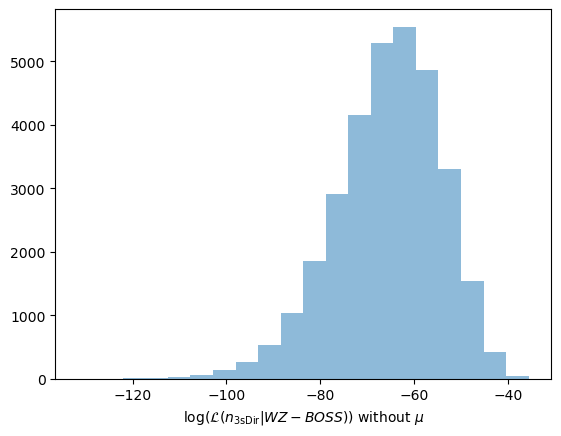

In [31]:
plt.hist(LL_nomag,bins=20,alpha=0.5)
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L}(n_{\rm 3sDir}\vert WZ -BOSS))$ without $\mu$')
plt.savefig('hist_L_nomag_WZ_BOSS.png')

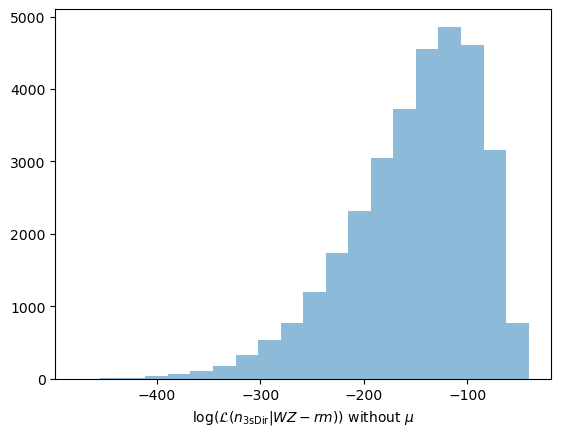

In [21]:
plt.hist(LL_nomag,bins=20,alpha=0.5)
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L}(n_{\rm 3sDir}\vert WZ -rm))$ without $\mu$')
plt.savefig('hist_L_nomag_WZ_rm.png')

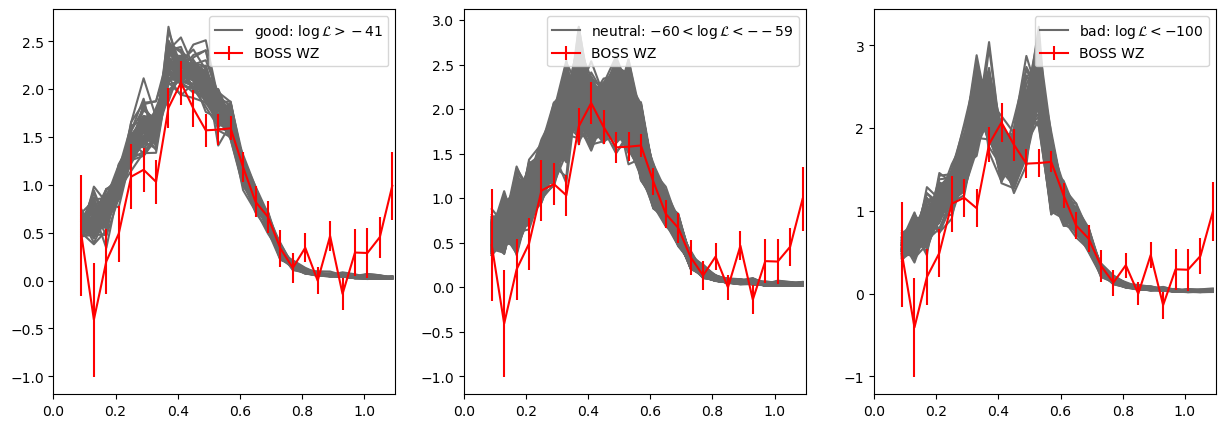

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
sel_good=((LL>=-41))
sel_mid=((LL<-59.)&(LL>-60))
sel_bad=((LL<-100))

ax1.errorbar(z_wz,w_wz/br_boss/w_dm_boss,yerr=[Cov_wz[i][i]**0.5/br_boss[i]/w_dm_boss[i] for i in range(26)],c='red',zorder=2,label='BOSS WZ')
for i in range(len(LL)):
    if sel_good[i]==True:
        ax1.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax1.plot(-10,0,color='dimgrey',label=r'good: $\log\mathcal{L}>-41$')
ax1.set_xlim(0,1.1)     

ax2.errorbar(z_wz,w_wz/br_boss/w_dm_boss,yerr=[Cov_wz[i][i]**0.5/br_boss[i]/w_dm_boss[i] for i in range(26)],c='red',zorder=2,label='BOSS WZ')
for i in range(len(LL)):
    if sel_mid[i]==True:
        ax2.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax2.plot(-10,0,color='dimgrey',label=r'neutral: $-60<\log\mathcal{L}<--59$')
ax2.set_xlim(0,1.1)

ax3.errorbar(z_wz,w_wz/br_boss/w_dm_boss,yerr=[Cov_wz[i][i]**0.5/br_boss[i]/w_dm_boss[i] for i in range(26)],c='red',zorder=2,label='BOSS WZ')
for i in range(len(LL)):
    if sel_bad[i]==True:
        ax3.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax3.plot(-10,0,color='dimgrey',label=r'bad: $\log\mathcal{L}<-100$')
ax3.set_xlim(0,1.1)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.savefig('Good_bad_L_nz.png')

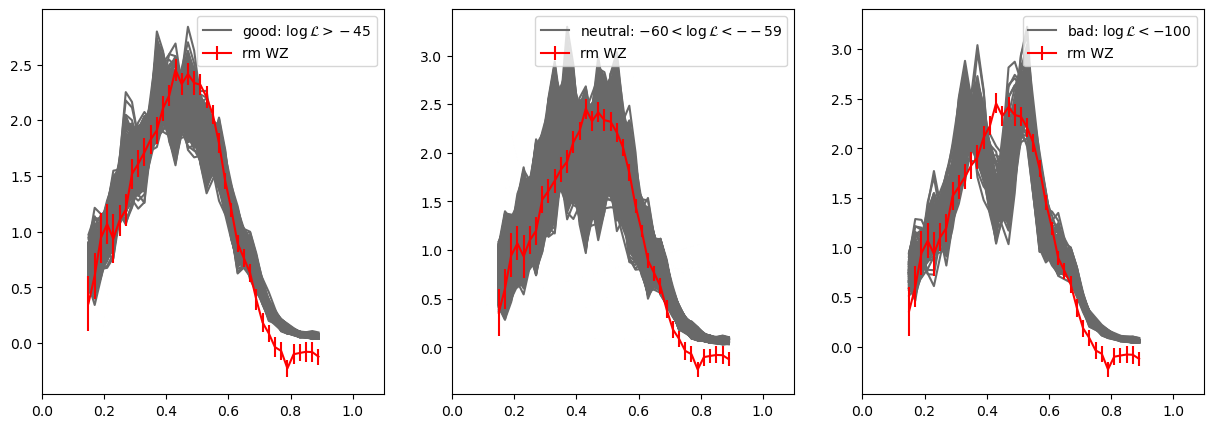

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
sel_good=((LL>=-45))
sel_mid=((LL<-50.)&(LL>-100))
sel_bad=((LL<-100))

ax1.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
for i in range(len(LL)):
    if sel_good[i]==True:
        ax1.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax1.plot(-10,0,color='dimgrey',label=r'good: $\log\mathcal{L}>-45$')
ax1.set_xlim(0,1.1)     

ax2.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
for i in range(len(LL)):
    if sel_mid[i]==True:
        ax2.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax2.plot(-10,0,color='dimgrey',label=r'neutral: $-100<\log\mathcal{L}<--50$')
ax2.set_xlim(0,1.1)

ax3.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
for i in range(len(LL)):
    if sel_bad[i]==True:
        ax3.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax3.plot(-10,0,color='dimgrey',label=r'bad: $\log\mathcal{L}<-100$')
ax3.set_xlim(0,1.1)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.savefig('Good_bad_L_nz_rm_nomag.png')

In [51]:
z_mean_good=[]
z_mean_bad=[]
z_mean_neutral=[]
z_mean_full=[]
for i in range(len(LL)):
    if sel_good[i]==True:
        z_mean_good.append(0.05*np.sum(z_y*Y[i]))
        
for i in range(len(LL)):
    if sel_mid[i]==True:
        z_mean_neutral.append(0.05*np.sum(z_y*Y[i]))
        
for i in range(len(LL)):
    if sel_bad[i]==True:
        z_mean_bad.append(0.05*np.sum(z_y*Y[i]))
for i in range(len(LL)):
    z_mean_full.append(0.05*np.sum(z_y*Y[i]))

In [52]:
z2_mean_good=[]
z2_mean_bad=[]
z2_mean_neutral=[]
z2_mean_full=[]
for i in range(len(LL)):
    if sel_good[i]==True:
        z2_mean_good.append(0.05*np.sum(z_y*Y[i]*z_y)-0.05**2*np.sum(z_y*Y[i])**2)
        
for i in range(len(LL)):
    if sel_mid[i]==True:
        z2_mean_neutral.append(0.05*np.sum(z_y*Y[i]*z_y)-0.05**2*np.sum(z_y*Y[i])**2)
        
for i in range(len(LL)):
    if sel_bad[i]==True:
        z2_mean_bad.append(0.05*np.sum(z_y*Y[i]*z_y)-0.05**2*np.sum(z_y*Y[i])**2)
for i in range(len(LL)):
    z2_mean_full.append(0.05*np.sum(z_y*Y[i]*z_y)-0.05**2*np.sum(z_y*Y[i])**2)

In [53]:
Id=np.array([1 for i in z_y])
z3_mean_good=[]
z3_mean_bad=[]
z3_mean_neutral=[]
z3_mean_full=[]
for i in range(len(LL)):
    if sel_good[i]==True:
        z3_mean_good.append(0.05*np.sum((z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Y[i]))
        
for i in range(len(LL)):
    if sel_mid[i]==True:
        z3_mean_neutral.append(0.05*np.sum((z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Y[i]))
        
for i in range(len(LL)):
    if sel_bad[i]==True:
        z3_mean_bad.append(0.05*np.sum((z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Y[i]))
for i in range(len(LL)):
    z3_mean_full.append(0.05*np.sum((z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Id*(z_y-0.05*np.sum(z_y*Y[i]))*Y[i]))

In [54]:
print(len(z_mean_good),len(z_mean_neutral),len(z_mean_bad),len(z_mean_full))

445 29830 156 32000


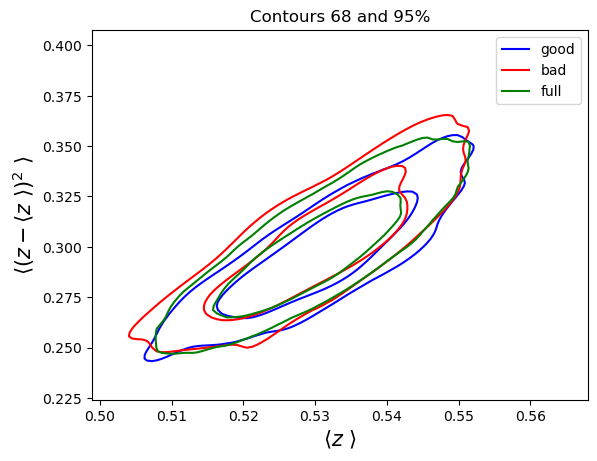

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

# Exemple de données
x1, y1 = z_mean_good,z2_mean_good
x2, y2 = z_mean_bad,z2_mean_bad
x3, y3 = z_mean_full,z2_mean_full

# Créer une figure
plt.figure()

# Définir les limites des axes
xmin = min(np.min(x1), np.min(x2), np.min(x3))
xmax = max(np.max(x1), np.max(x2), np.max(x3))
ymin = min(np.min(y1), np.min(y2), np.min(y3))
ymax = max(np.max(y1), np.max(y2), np.max(y3))

# Fonction pour calculer les niveaux de contour pour des pourcentages donnés
def calculate_contour_levels(density, percentiles):
    sorted_density = np.sort(density.flatten())
    cumulative_density = np.cumsum(sorted_density)
    cumulative_density /= cumulative_density[-1]
    levels = [sorted_density[np.searchsorted(cumulative_density, p)] for p in percentiles]
    return levels

# Fonction pour tracer les contours d'un ensemble de points
def plot_contours(x, y, color):
    k = scipy.stats.gaussian_kde([x, y])
    xi, yi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    levels = calculate_contour_levels(zi, [0.05, 0.33])  # 30% (0.7) et 90% (0.1)
    plt.contour(xi, yi, zi.reshape(xi.shape), levels=levels, colors=color)

# Tracer les contours des trois ensembles de points
plot_contours(x1, y1, 'blue')
plot_contours(x2, y2, 'red')
plot_contours(x3, y3, 'green')

plt.plot(0.55,0.3,'blue',label='good')
plt.plot(0.55,0.3,'red',label='bad')
plt.plot(0.55,0.3,'green',label='full')
# Ajouter une légende
plt.legend()

# Afficher la figure
plt.xlabel(r'$\langle z \rangle$',fontsize=15)
plt.ylabel(r'$\langle (z-\langle z \rangle)^2 \rangle$',fontsize=15)
plt.title('Contours 68 and 95%')

plt.savefig('Impact_LWZ_meanz.png',bbox_inches='tight')

# With Magnification 

The magnification contribution is $M.p$, 

$p=(b_u \frac{\alpha_{r}}{\alpha_{r}^{\rm fid}},\, \alpha_u)$

$M_{i,0}=\frac{3H_0^2\Omega_m}{2c^2}\times \alpha_r^{\rm fid}(z_i)\times \Sigma_{j\vert z_j<z_i} \omega_{DM}(z_j)\frac{n_u(z_j)}{a(z_j)}\frac{\chi(z_j)}{\chi(z_i)}(\chi(z_i)-\chi(z_j))\Delta \chi_j$

$M_{i,1}=\frac{3H_0^2\Omega_m}{2c^2}\times b_r(z_i) \times  \Sigma_{j\vert z_j>z_i}\omega_{DM}(z_i)\times\frac{n_u(z_j)}{a(z_i)}\frac{\chi(z_i)}{\chi(z_j)}(\chi(z_j)-\chi(z_i))\Delta \chi_i$

we adopted the convention $\alpha:=2(\tilde{\alpha}-1)$

### Magnification

In [107]:
import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)
def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

H0=70
c=300*10**3
Omega_m=0.315
Magn_cst=3*H0**2*Omega_m/c**2/2

dz_boss=0.04
dz_rm=0.02

In [61]:
Magn_cst

2.5725e-08

## Likelihood

In [157]:
def log_L_WZ(n,M,Pr_s,Pr_p,mu_p,ref):
    # n is the n(z), normalised
    # M the max sys order, Pr_s the priors on sys
    # Pr_p the sigma of the priors on Magn, and mu_p their center 
    # ref the reference sample: either boss or rm 
    
    Pr_s=np.array(Pr_s[: M],dtype=np.float64)
    mu_s=np.array([0 for i in range(M)],dtype=np.float64)
        
    priors_q=np.concatenate((Pr_s,Pr_p))
    mu_q=np.concatenate((mu_s,mu_p))
    
    C_q=np.diag(priors_q**2)
    Sigma_q=np.linalg.inv(C_q)
    det_q=np.linalg.det(Sigma_q)
    
    
    dz_2=(z_wz[1]-z_wz[0])
    dchi=[chi(z_wz[i]+dz_2)-chi(z_wz[i]-dz_2) for i in range(len(z_wz))]
    
    if ref=='boss':
        c=np.array(w_wz-n*w_dm_boss*br_boss,dtype=np.float64)
        As=np.array([[n[i]*w_dm_boss[i]*br_boss[i]*ak[k]*Pk[k][i]for k in range(M)] for i in range(Nz)],dtype=np.float64)
        
        S1=[[n[j]*(1+z_wz[j])*chi(z_wz[j])/chi(z_wz[i])*(chi(z_wz[i])-chi(z_wz[j]))*w_dm_boss[j]*dchi[i] for j in range(Nz)] for i in range(Nz)]
        S2=[[n[j]*(1+z_wz[i])*chi(z_wz[i])/chi(z_wz[j])*(chi(z_wz[j])-chi(z_wz[i]))*w_dm_boss[i]*dchi[i] for j in range(Nz)] for i in range(Nz)]
        
        Mi0=[Magn_cst*alpha_boss[i]*np.sum(S1[i][:i]) for i in range(Nz)]
        Mi1=[Magn_cst*br_boss[i]*np.sum(S2[i][i:]) for i in range(Nz)]
        
        Mp=np.transpose(np.array([Mi0,Mi1],dtype=np.float64))
        
        A=np.hstack((As,Mp))
        
    if ref=='rm':
        c=np.array(w_wz-n*br_red*w_dm_red,dtype=np.float64)
        As=np.array([[n[i]*br_red[i]*w_dm_red[i]*ak[k]*Pk[k][i]for k in range(M)] for i in range(Nz)],dtype=np.float64)
        
        S1=[[n[j]*(1+z_wz[j])*chi(z_wz[j])/chi(z_wz[i])*(chi(z_wz[i])-chi(z_wz[j]))*w_dm_red[j]*dchi[i] for j in range(Nz)] for i in range(Nz)]
        S2=[[n[j]*(1+z_wz[i])*chi(z_wz[i])/chi(z_wz[j])*(chi(z_wz[j])-chi(z_wz[i]))*w_dm_red[i]*dchi[i] for j in range(Nz)] for i in range(Nz)]
        
        Mi0=[Magn_cst*alpha_red[i]*np.sum(S1[i][:i]) for i in range(Nz)]
        Mi1=[Magn_cst*br_red[i]*np.sum(S2[i][i:]) for i in range(Nz)]
        
        Mp=np.transpose(np.array([Mi0,Mi1],dtype=np.float64))
        
        
        A=np.hstack((As,Mp))
    
    #now second variables:
    alpha=np.einsum('ji,jk,kl',A,Sigma_wz,A)+ Sigma_q
    alpha_inv=np.linalg.inv(alpha)
    
    beta=np.einsum('ji,jk,k',A,Sigma_wz,c)+np.einsum('jk,k',Sigma_q,mu_q)
    gamma=np.einsum('j,jk,k',c,Sigma_wz,c)+np.einsum('j,jk,k',mu_q,Sigma_q,mu_q)
    
    #compute the likelihood ingredients
    det_alpha=abs(np.linalg.det(alpha))
    log_exp=-1/2*(gamma-np.einsum('j,jk,k',beta,alpha_inv,beta))
    
    return (-1/2)*np.log(det_alpha)+log_exp+1/2*np.log(det_q)#*det_wz**0.5
 

## Open 3sDir

In [108]:
X = np.load('/global/u2/d/dhayaa/BFD_nz/notebooks/20240427/nz_samples_newmethod.npy')
Y=[]
for i in range(np.size(X,0)):
    Y.append(X[i][0]/0.05)

In [109]:
def interpolation_lineaire(X0, Y0, X1):
    # Création de la fonction d'interpolation linéaire
    f = interp1d(X0, Y0, kind='linear', fill_value="extrapolate")
    # Application de la fonction d'interpolation aux abscisses X1
    Y1 = f(X1)
    return Y1

z_y=[0.025+i*0.05 for i in range(100)]

Nz_SOM=[]
z_som=[]
for i in range(np.size(Y,0)):
    Nz_SOM.append(interpolation_lineaire(z_y, Y[i],z_wz ))

print(np.shape(Nz_SOM))


(32000, 26)


In [158]:
start_time=time.time()
Pr=[0.5,0.1,0.05,0.05,0.05]
Pr_mag=[5,5]
mu_mag=[1,1]

M=5
LL_boss=[]
for i in range(10000):
    LL_boss.append((log_L_WZ(Nz_SOM[i],M,Pr,Pr_mag,mu_mag,'boss'))      )   
LL_boss=np.array(LL_boss)
sel=((LL_boss>-10000))
print(len(LL_boss[sel]))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL_boss[sel])/(end_time - start_time),0)} eval/seconde")

10000
Time running : 99.47861456871033 secondes
101.0 eval/seconde


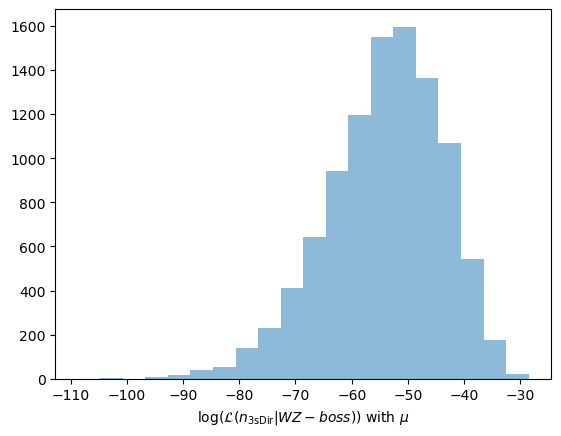

In [159]:
plt.hist(LL_boss,bins=20,alpha=0.5)
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L}(n_{\rm 3sDir}\vert WZ -boss))$ with $\mu$')
plt.savefig('hist_L_WZ_boss.png')

In [99]:
start_time=time.time()
Pr=[0.5,0.1,0.05,0.05,0.05]
Pr_mag=[5,5]
mu_mag=[1,1]

M=5
LL=[]
for i in range(10000):
    LL.append((log_L_WZ(Nz_SOM[i],M,Pr,Pr_mag,mu_mag,'rm'))      )   
LL=np.array(LL)
sel=((LL>-10000))
print(len(LL[sel]))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL[sel])/(end_time - start_time),0)} eval/seconde")

10000
Time running : 305.90806555747986 secondes
33.0 eval/seconde


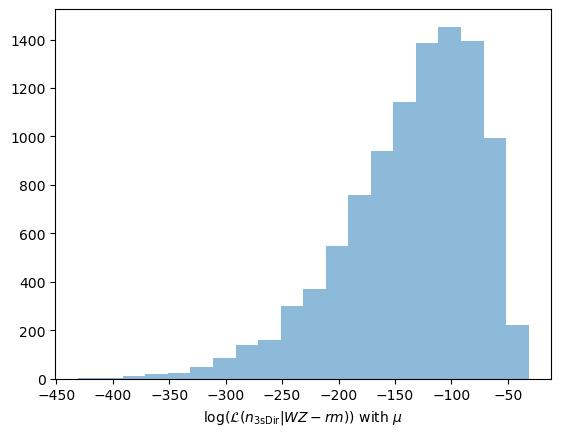

In [100]:
plt.hist(LL,bins=20,alpha=0.5)
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L}(n_{\rm 3sDir}\vert WZ -rm))$ with $\mu$')
plt.savefig('hist_L_WZ_rm.png')

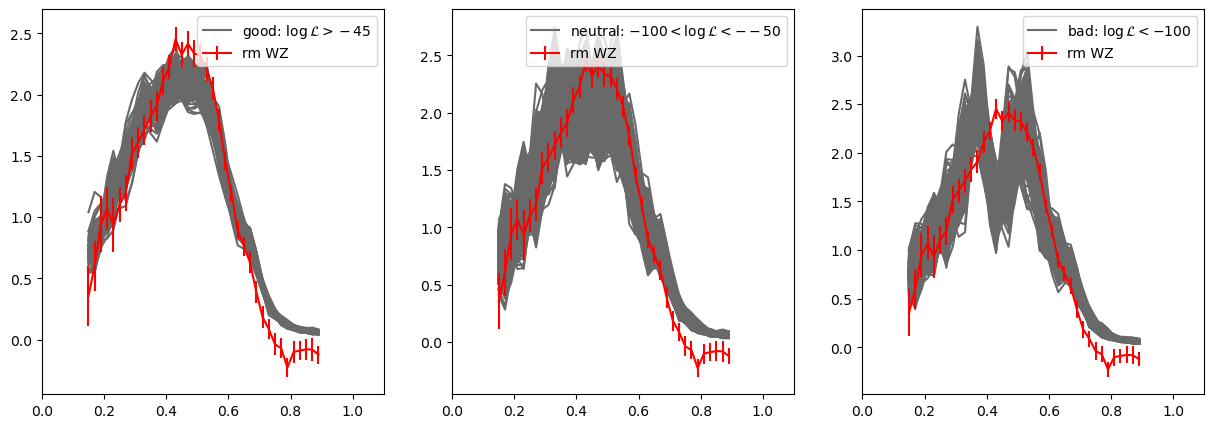

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
sel_good=((LL>=-45))
sel_mid=((LL<-70.)&(LL>-100))
sel_bad=((LL<-250))

ax1.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
for i in range(len(LL)):
    if sel_good[i]==True:
        ax1.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax1.plot(-10,0,color='dimgrey',label=r'good: $\log\mathcal{L}>-45$')
ax1.set_xlim(0,1.1)     

ax2.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
for i in range(len(LL)):
    if sel_mid[i]==True:
        ax2.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax2.plot(-10,0,color='dimgrey',label=r'neutral: $-100<\log\mathcal{L}<--50$')
ax2.set_xlim(0,1.1)

ax3.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
for i in range(len(LL)):
    if sel_bad[i]==True:
        ax3.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
ax3.plot(-10,0,color='dimgrey',label=r'bad: $\log\mathcal{L}<-100$')
ax3.set_xlim(0,1.1)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.savefig('Good_bad_L_nz_rm.png')

In [102]:
LL_red=np.copy(LL)

In [154]:
LL_combined=LL_red+LL_boss
sel_good_boss=((LL_boss>-40))
sel_good_red=((LL_red>-50))

sel_both_good=((LL_red>-50) & (LL_boss>-40))
sel_good_combined=((LL_combined>-80))

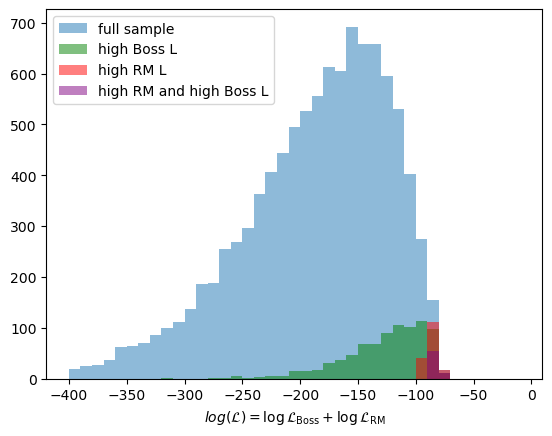

In [156]:
B=[-400+i*10 for i in range(40)]
plt.hist(LL_combined,bins=B,alpha=0.5,label='full sample')
plt.xlabel(r'$log(\mathcal{L})=\log\mathcal{L}_{\rm Boss}+\log\mathcal{L}_{\rm RM}$')
plt.hist(LL_combined[sel_good_boss],bins=B,alpha=0.5,color='green',label='high Boss L')
plt.hist(LL_combined[sel_good_red],bins=B,alpha=0.5,color='red',label='high RM L')
plt.hist(LL_combined[sel_both_good],bins=B,alpha=0.5,color='purple',label='high RM and high Boss L')

plt.legend()

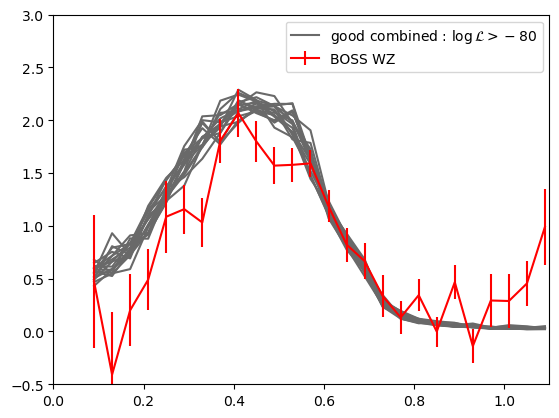

In [164]:
plt.figure(dpi=100)

#plt.errorbar(z_wz,w_wz/br_red/w_dm_red,yerr=[Cov_wz[i][i]**0.5/br_red[i]/w_dm_red[i] for i in range(Nz)],c='red',zorder=2,label='rm WZ')
plt.errorbar(z_wz,w_wz/br_boss/w_dm_boss,yerr=[Cov_wz[i][i]**0.5/br_boss[i]/w_dm_boss[i] for i in range(26)],c='red',zorder=2,label='BOSS WZ')
Index=np.array([i for i in range(len(LL_combined))])[sel_good_combined]

for i in Index:
    plt.plot(z_wz,Nz_SOM[i],c='dimgrey',zorder=1)
plt.plot(-10,0,color='dimgrey',label=r'good combined : $\log\mathcal{L}>-80$')
plt.xlim(0,1.1)
plt.ylim(-0.5,3)
plt.legend(loc='upper right')


# Testing the improvement of magn

Comparison of the Likelihood amplitude with and without th

In [136]:
start_time=time.time()
Pr=[0.5,0.1,0.05,0.05,0.05]
Pr_mag=[5,5]
mu_mag=[1,1]

M=5
LL=[]
for i in range(1000):
    LL.append((log_L_WZ(Nz_SOM[i],M,Pr,Pr_mag,mu_mag,'boss'))      )   
LL=np.array(LL)
sel=((LL>-100000))
print(len(LL[sel]))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL[sel])/(end_time - start_time),0)} eval/seconde")

1000
Time running : 13.676257610321045 secondes
73.0 eval/seconde


In [139]:
start_time=time.time()
Pr=[0.5,0.1,0.05,0.05,0.05]
M=5
LL_nomag=[]
for i in range(1000):
    LL_nomag.append((log_L_no_magn(Nz_SOM[i],M,Pr,'boss')))      
LL_nomag=np.array(LL_nomag)
sel=((LL_nomag>-100000))
print(len(LL_nomag[sel]))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL[sel])/(end_time - start_time),0)} eval/seconde")

1000
Time running : 0.21361398696899414 secondes
4681.0 eval/seconde


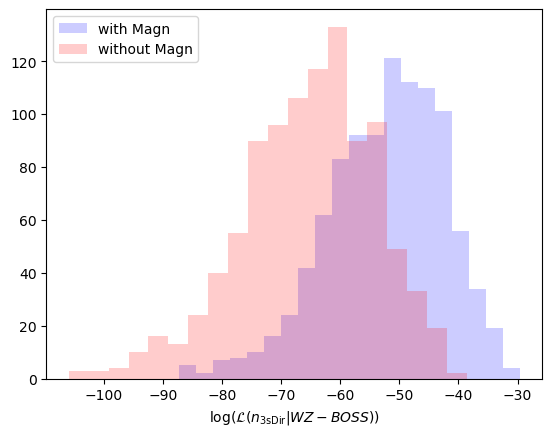

In [140]:
plt.hist(LL[sel],bins=20,alpha=0.2,color='blue',label='with Magn')
plt.hist(LL_nomag[sel],bins=20,alpha=0.2,color='red',label='without Magn')

#plt.hist((LL_noM)[:10000],bins=20,alpha=0.5,color='dimgrey')
plt.legend()
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L}(n_{\rm 3sDir}\vert WZ -BOSS))$')
plt.savefig('hist_L_WZBOSS.png')

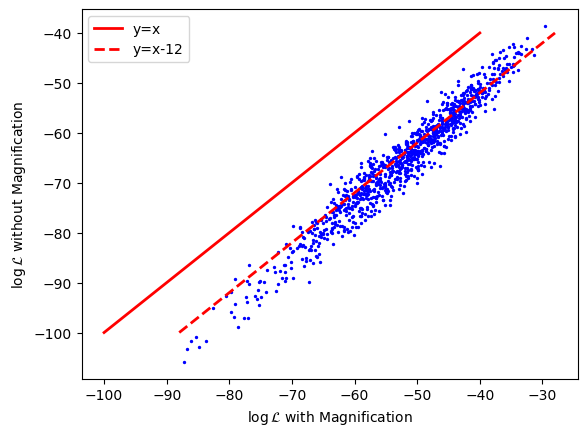

In [146]:
plt.scatter(LL[sel],LL_nomag[sel],color='blue',s=2)
#plt.hist(LL_nomag[sel],bins=20,alpha=0.2,color='red',label='without Magn')
plt.plot([-100,-40],[-100,-40],c='red',linewidth=2,label='y=x')
plt.plot([-88,-28],[-100,-40],c='red',linewidth=2,label='y=x-12',linestyle='--')
#plt.hist((LL_noM)[:10000],bins=20,alpha=0.5,color='dimgrey')
plt.legend()
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log\mathcal{L}$ with Magnification')
plt.ylabel(r'$\log\mathcal{L}$ without Magnification')
plt.savefig('hist_L_WZBOSS.png')

In [82]:
start_time=time.time()
Pr=[0.5,0.1,0.05,0.05,0.05]
Pr_mag=[5,5]
mu_mag=[1,1]

M=5
LL=[]
for i in range(1000):
    LL.append((log_L_WZ(Nz_SOM[i],M,Pr,Pr_mag,mu_mag,'rm'))      )   
LL=np.array(LL)
sel=((LL>-10000))
print(len(LL[sel]))

end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL[sel])/(end_time - start_time),0)} eval/seconde")

1000
Time running : 30.092036962509155 secondes
33.0 eval/seconde


In [83]:
start_time=time.time()
Pr=[0.5,0.1,0.05,0.05,0.05]
M=5
LL_nomag=[]
for i in range(1000):
    LL_nomag.append((log_L_no_magn(Nz_SOM[i],M,Pr,'rm'))     )   
LL_nomag=np.array(LL_nomag)
sel=((LL_nomag>-10000))
print(len(LL_nomag[sel]))
end_time = time.time()

print(f"Time running : {end_time - start_time} secondes")
print(f"{round(len(LL[sel])/(end_time - start_time),0)} eval/seconde")

1000
Time running : 0.30133533477783203 secondes
3319.0 eval/seconde


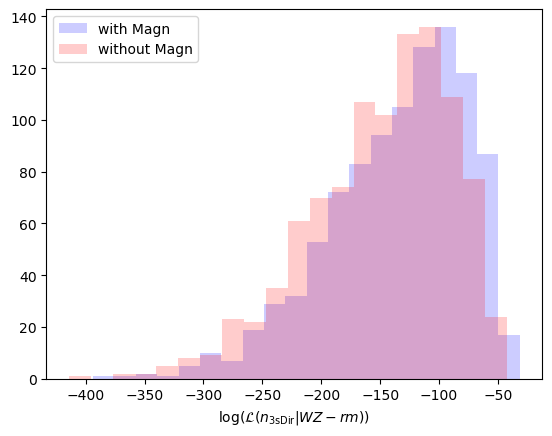

In [84]:
plt.hist(LL[sel],bins=20,alpha=0.2,color='blue',label='with Magn')
plt.hist(LL_nomag[sel],bins=20,alpha=0.2,color='red',label='without Magn')

#plt.hist((LL_noM)[:10000],bins=20,alpha=0.5,color='dimgrey')
plt.legend()
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L}(n_{\rm 3sDir}\vert WZ -rm))$')
plt.savefig('hist_L_WZrm.png')

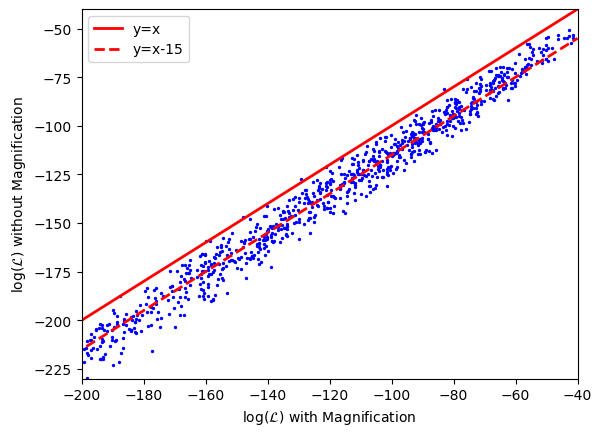

In [88]:
plt.scatter(LL[sel],LL_nomag[sel],color='blue',s=2)
#plt.hist(LL_nomag[sel],bins=20,alpha=0.2,color='red',label='without Magn')
plt.plot([-400,-40],[-400,-40],c='red',linewidth=2,label='y=x')
plt.plot([-400,-40],[-415,-55],c='red',linewidth=2,linestyle='--',label='y=x-15')
#plt.hist((LL_noM)[:10000],bins=20,alpha=0.5,color='dimgrey')
plt.legend()
#plt.hist(LL1,bins=20,alpha=0.5)
plt.xlabel(r'$\log(\mathcal{L})$ with Magnification')
plt.ylabel(r'$\log(\mathcal{L})$ without Magnification')
plt.xlim(-200,-40)
plt.ylim(-230,-40)
plt.savefig('hist_L_WZrm.png')

# Posterior on magnification, toy model

We take for the n(z), the normalised WZ without the negative high-z tail, and vary the mu_alpha_red to see what is the values that maximise the likelihood (by recovering the high z negative tail)

Text(0, 0.5, '$\\log(\\mathcal{L})$')

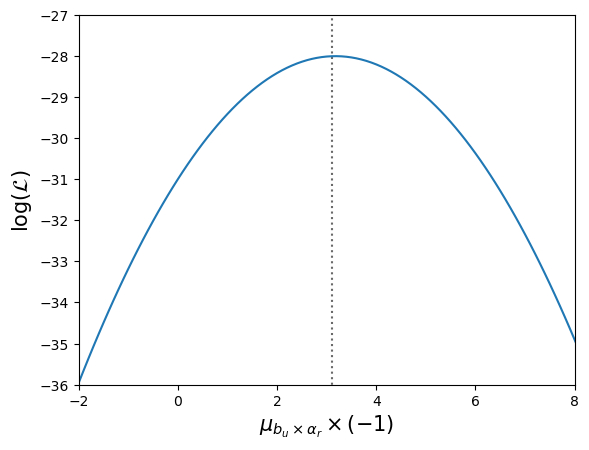

In [98]:
# Evaluate best magn coeff:

w_wz_p=np.copy(w_wz)
for i in range(len(w_wz_p)):
    if w_wz_p[i]<0:
        w_wz_p[i]=0
        
norm=np.sum(w_wz_p)*0.02
L_m=[]
Mag=[-2.5+i*0.1 for i in range(125)]
for m in Mag:
    L_m.append(log_L_WZ(np.array(w_wz_p)/norm,5,[0.5,0.05,0.05,0.05,0.05],[1,5],[m,1],'rm'))

plt.figure(dpi=100)
plt.plot([3.1,3.1],[-40,-27],c='dimgrey',linestyle='dotted')
plt.ylim(-36,-27)
plt.xlim(-2,8)

plt.plot(Mag,L_m)
plt.xlabel(r'$\mu_{b_u\times \alpha_{r}}\times (-1)$',fontsize=15)
plt.ylabel(r'$\log(\mathcal{L})$',fontsize=15)